# Neural Network Jupyter Notebook

The notebook contains all the neccessary code to create a neural network from a training set. 

It is based on the **Torch** framework, and also utilize the **train_test_split** function from the *scikit-learn* library.

The training data is created with the locally imported function **make_training_sets**, and the success of the created neural network is plotted using the locally imported function **create_plots**.

In [1]:
import torch
from sklearn.model_selection import train_test_split
from alsoft_ann_training_sets import make_training_sets
from alsoft_ann_testing import create_plots

## Preparation of training sets

The function **prepare_training_sets** splits the input and target data into training, testing and validation sets.

In [2]:
def prepare_training_sets(inputs_tensor, targets_tensor, test_size, val_size, random_state):
    inputs_train, inputs_temp, targets_train, targets_temp = train_test_split(
        inputs_tensor, targets_tensor, test_size=test_size + val_size, random_state=random_state)
    inputs_test, inputs_val, targets_test, targets_val = train_test_split(
        inputs_temp, targets_temp, test_size=val_size/(test_size + val_size), random_state=random_state)
    return inputs_train, inputs_test, inputs_val, targets_train, targets_test, targets_val

## Neural Network Class

The class **ANN** subclasses the **Module** class from PyTorch. It is used to create a Neural Network Object that contains all the connected nodes in a fully-connected Neural Network with all the weights and biases. 

The **__init__** function initializes an Artificial Neural Network according to a specified number of nodes in each layer (*'layers'*) and the activation function (*'activation_func'*).

The **forward** function performs a forward pass through the network with the input tensor *'x'*.

In [3]:
class ANN(torch.nn.Module):
    def __init__(self, layers, activation_func):
        super(ANN, self).__init__()
        self.layers = layers
        self.num_layers = len(layers)
        self.fc_layers = torch.nn.ModuleList()
        self.activation_func = activation_func
        for i in range(self.num_layers - 1):
            self.fc_layers.append(torch.nn.Linear(layers[i], layers[i+1]))
    
    def forward(self, x):
        for i in range(self.num_layers - 2):
            x = self.activation_func(self.fc_layers[i](x))
        x = self.fc_layers[-1](x)
        return x

## Training loop

The function **train_model** will train an initialized *'ann'* object according to a network architecture specified by the optimizer, number of epochs, patience, batch size, and learning rate. It trains the network using the already partitioned *'prepared_training_sets'*, and save the network according to the *'ann_filename'*.

In [4]:
def train_model(ann_object, optimizer, num_epochs, patience, batch_size, learning_rate,
                prepared_training_sets, ann_filename):
    ann_file_path = '../artificial_neural_networks/alsoft_neural_networks/' + ann_filename + '.pth'
    inputs_train, inputs_test, inputs_val, targets_train, targets_test, targets_val = prepared_training_sets
    criterion = torch.nn.MSELoss()
    optimizer = optimizer(ann_object.parameters(), lr=learning_rate)
    best_val_loss = float('inf')
    early_stop_counter = 0
    for epoch in range(num_epochs):
        for i in range(0, len(inputs_train), batch_size):
            input_batch = inputs_train[i:i+batch_size]
            target_batch = targets_train[i:i+batch_size]
            labels = ann_object(input_batch)
            loss = criterion(labels, target_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        ann_object.eval()
        with torch.no_grad():
            val_labels = ann_object(inputs_val)
            val_loss = criterion(val_labels, targets_val)
        print(f'Epoch [{epoch+1}/{num_epochs}], MSE from validation-set: {val_loss.item():.2f}')
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
            torch.save(ann_object.state_dict(), ann_file_path)
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                break
    end_epoch = epoch + 1
    ann_object.eval()
    with torch.no_grad():
        test_labels = ann_object(inputs_test)
        test_loss = criterion(test_labels, targets_test)
    residuals = test_labels - targets_test
    std = torch.std(residuals).item()
    print(f"Mean Squared Error (MSE) from test-set: {test_loss.item():.2f}")
    print(f"Standard Deviation (STD) from test-set: {round(std,2)}")
    return residuals

## Training data creation and preparation

With all the neccessary functions defined, it is possible to build the network. Firstly, the training data needs to be defined.

The following example is set for an ALSOFT implementation, and the training data consist of the flow stress calculated from the time, temperature, and effective consentration of a modelled post-extrusion softening. 

The function **make_training_sets** takes the parameters *'alloy_index'*, *'inputs_filename'*, *'targets_filename'*, *'input_items'* and *'input_ranges'*. It utilizes the Extention Module for the Fortran implemented ALSOFT code to run ALSOFT for every temperature and effective concentration combination that a user specifies. The Fortran implementation simulates the softening behaviour after extrusion for a time corresponding to a users choice.

*'alloy_index'* needs to be an integer between 0 and 3, and it corresponds to an alloy specific input file that ALSOFT requires to run the simulation. The filenames inputs_filename and *'targets_filename'* are the paths where the inputs and targets are saved. They are conventionally saved using the *'.pt'* extention. 

In [5]:
alloy_index = [2]   # ['1xxx', '3xxx', '6060', '6082']
inputs_filename = 'ann_07_06_2024_inputs.pt'  
targets_filename = 'ann_07_06_2024_targets.pt'

*'input_items'* specifies how many different time - temperature - effective concentration conditions that the training data will consist of ( [time_items, temp_items, ceff_items] ), and the *'input_ranges'* specify . The function will linearly divide *'temp_items'* elements between the *'temp_range[0]'* and *'temp_range[1]'*, and it will linearly divide *'ceff_items'* elements between the *'ceff_range[0]'* and *'ceff_range[1]'*. 

**make_training_sets** will conduct a Fortran simulation for every temperature - effective concentration pair over a time cycle according to the users selected time range. Because the Fortran implementation might return a more numerous set of time-stress values for each temperature - effective concentration pair than desired, the function will only store *'time_items'* elements of temperature - effective concentration  pairs for each simulation.

Each [time, temperature, effective concentration] combination will saved as a tensor, and all these tensors will be stacked to a two-dimensional tensor that is saved under *'inputs_filename'*. The flow stress value for each condition will be saved in a tensor saved under *'targets_filename'*

In [6]:
time_items = 335
time_range = [1e-3 , 1e3]
temp_items = 30
temp_range = [300, 500]
ceff_items = 10
ceff_range = [0.0053138, 0.053138]
input_items = [time_items, temp_items, ceff_items]
input_ranges = [time_range, temp_range, ceff_range]

data_points = make_training_sets(alloy_index, inputs_filename, targets_filename, input_items, input_ranges)
print("Number of training data points: " + str(data_points))

Producing training sets for ranges in time [s]: [0.001, 1000.0], temperatures [Celsius]: [300, 500] and effective concentrations: [0.0053138, 0.053138]
...
Training data containing: 115500 elements, saved to ann_07_06_2024_inputs.pt and ann_07_06_2024_targets.pt
Number of training data points: 115500


The input tensor and target tensor are retrieved from their saved location using the **torch.load** function. They are divided into the training set, validation set and test set using the **prepare_training_sets** function.

In [7]:
inputs_tensor = torch.load('../artificial_neural_networks/alsoft_ann_inputs_targets/' + inputs_filename)
targets_tensor = torch.load('../artificial_neural_networks/alsoft_ann_inputs_targets/' + targets_filename)
prepared_training_sets = prepare_training_sets(inputs_tensor, targets_tensor, test_size=0.15, val_size=0.15, random_state=14)

## Neural Network construction

The neural network object can now be constructed from the **ANN** class. 

The *'layers'* parameter consist of the input layer with the required number of nodes (3 for ALSOFT, corresponding to time, temperature, and effective concentration), the desired number of nodes in each desired hidden layer, and the output layer with the required number of nodes (1 for ALSOFT, corresponding to the flow stress).

The *'activation_func'* parameter needs to be one of PyTorch's included activation functions, such as *'relu'*, *'sigmoid'*, *'tanh'*, or several others.

In [8]:
layers = [3,60,40,1]
activation_func = torch.relu
alsoft_ann = ANN(layers, activation_func)

## Network training

The next task is to train the network using the **train_model** function. This function takes the already untrained neural network object *'ann'* as a parameter, as well as the *'optimizer'*, *'learning_rate'*, *'num_epochs'*, *'patience'* and *'batch_size'*.

The *'optimizer'* needs to be an class from the **torch.optim** module, and an optimizer object will be constructed in the **train_model** function according to the specific *'optimizer'* and *'learning_rate'*. *'num_epochs'* determines the maximum number of epochs for the training process, and the *'patience'* determines how many epochs without validation loss improvement is tolerated. *'batch_size'* determines how many input elements that are forward propogated at the same time.

**train_model** returns *'residuals'*, which is a tensor containing the error between each target from the test set and the models output.

In [9]:
alsoft_ann_filename = 'ann_07_06_2024'
optimizer = torch.optim.Adam
learning_rate = 0.001
num_epochs = 500
patience = num_epochs/10
batch_size = 50
residuals = train_model(
    alsoft_ann, optimizer, num_epochs, patience, batch_size , learning_rate, prepared_training_sets,alsoft_ann_filename)

Epoch [1/500], MSE from validation-set: 605.91
Epoch [2/500], MSE from validation-set: 581.50
Epoch [3/500], MSE from validation-set: 552.20
Epoch [4/500], MSE from validation-set: 275.23
Epoch [5/500], MSE from validation-set: 150.53
Epoch [6/500], MSE from validation-set: 120.01
Epoch [7/500], MSE from validation-set: 80.36
Epoch [8/500], MSE from validation-set: 75.86
Epoch [9/500], MSE from validation-set: 70.59
Epoch [10/500], MSE from validation-set: 68.71
Epoch [11/500], MSE from validation-set: 71.87
Epoch [12/500], MSE from validation-set: 73.73
Epoch [13/500], MSE from validation-set: 77.30
Epoch [14/500], MSE from validation-set: 78.04
Epoch [15/500], MSE from validation-set: 81.79
Epoch [16/500], MSE from validation-set: 71.64
Epoch [17/500], MSE from validation-set: 68.98
Epoch [18/500], MSE from validation-set: 62.41
Epoch [19/500], MSE from validation-set: 56.86
Epoch [20/500], MSE from validation-set: 53.39
Epoch [21/500], MSE from validation-set: 62.83
Epoch [22/500], 

Epoch [175/500], MSE from validation-set: 19.05
Epoch [176/500], MSE from validation-set: 30.67
Epoch [177/500], MSE from validation-set: 11.05
Epoch [178/500], MSE from validation-set: 14.39
Epoch [179/500], MSE from validation-set: 6.92
Epoch [180/500], MSE from validation-set: 9.23
Epoch [181/500], MSE from validation-set: 13.10
Epoch [182/500], MSE from validation-set: 6.86
Epoch [183/500], MSE from validation-set: 13.42
Epoch [184/500], MSE from validation-set: 6.45
Epoch [185/500], MSE from validation-set: 9.39
Epoch [186/500], MSE from validation-set: 9.70
Epoch [187/500], MSE from validation-set: 8.92
Epoch [188/500], MSE from validation-set: 10.67
Epoch [189/500], MSE from validation-set: 9.14
Epoch [190/500], MSE from validation-set: 8.84
Epoch [191/500], MSE from validation-set: 8.53
Epoch [192/500], MSE from validation-set: 9.51
Epoch [193/500], MSE from validation-set: 8.09
Epoch [194/500], MSE from validation-set: 11.65
Epoch [195/500], MSE from validation-set: 6.75
Epoch

Epoch [350/500], MSE from validation-set: 5.68
Epoch [351/500], MSE from validation-set: 4.10
Epoch [352/500], MSE from validation-set: 7.09
Epoch [353/500], MSE from validation-set: 5.15
Epoch [354/500], MSE from validation-set: 5.67
Epoch [355/500], MSE from validation-set: 5.58
Epoch [356/500], MSE from validation-set: 4.06
Epoch [357/500], MSE from validation-set: 6.06
Epoch [358/500], MSE from validation-set: 4.83
Epoch [359/500], MSE from validation-set: 8.08
Epoch [360/500], MSE from validation-set: 4.07
Epoch [361/500], MSE from validation-set: 4.18
Epoch [362/500], MSE from validation-set: 4.08
Epoch [363/500], MSE from validation-set: 5.20
Epoch [364/500], MSE from validation-set: 6.50
Epoch [365/500], MSE from validation-set: 6.79
Epoch [366/500], MSE from validation-set: 4.64
Epoch [367/500], MSE from validation-set: 4.91
Epoch [368/500], MSE from validation-set: 3.99
Epoch [369/500], MSE from validation-set: 4.57
Epoch [370/500], MSE from validation-set: 4.30
Epoch [371/50

## Neural Network Plotting

The locally imported function **create_plots** creates a histogram from the test errors tensor *'residuals'*, as well as a comparison plot of ALSOFT against the ANN for three different [temperature, effective concentration] conditions

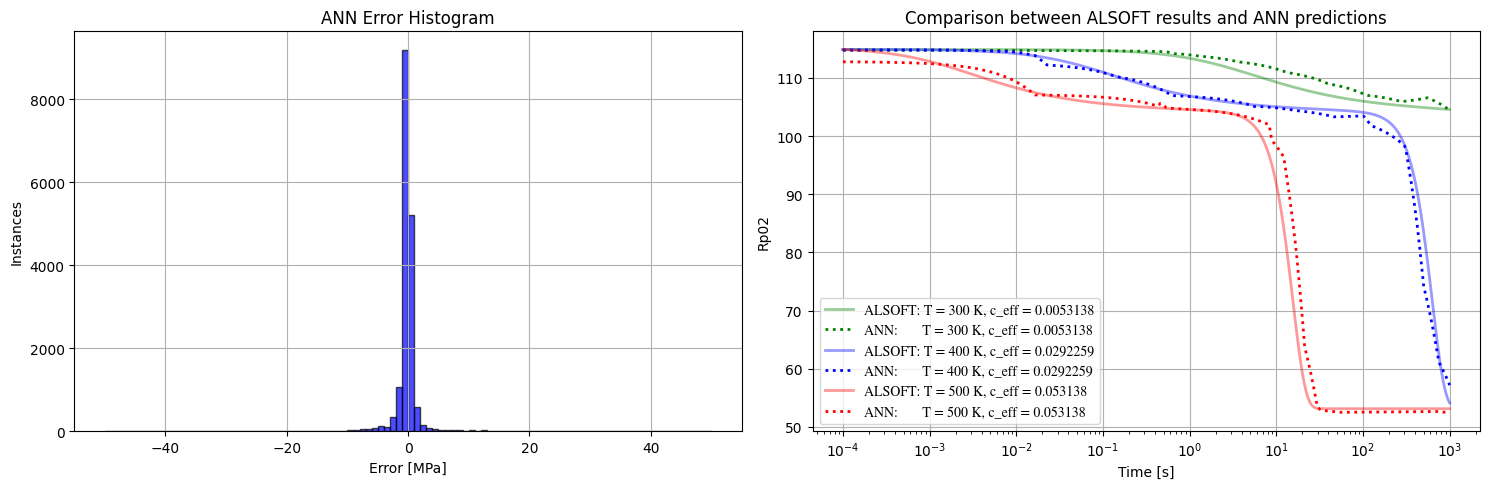

In [10]:
create_plots(time_range, temp_range, ceff_range, alloy_index, alsoft_ann_filename, alsoft_ann, residuals)